In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

# Static Covariates

Static covariates are characteristics of a time series / constants which do not change over time. When dealing with multiple time series, static covariates can help specific models improve forecasts. Darts' models will only consider static covariates embedded in the target series (the series for which we want to predict future values) and not past and/or future covariates (external data).

In this tutorial we look at:

1. how to define static covariates (numeric and/or categorical)
2. how to add static covariates to an existing **target** series
3. how to add static covariates at TimeSeries creation
4. how to use TimeSeries.from_group_dataframe() for automatic extraction of TimeSeries with embedded static covariates
5. how to scale/transform/encode static covariates embedded in your series
6. how to use static covariates with Darts' models

We start by generating a multivariate time series with three components `["comp1", "comp2", "comp3"]`

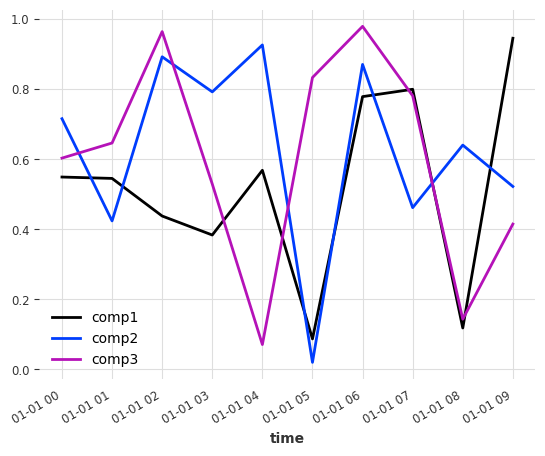

In [4]:
np.random.seed(0)
series = TimeSeries.from_times_and_values(
    times=pd.date_range(start="2020-01-01", periods=10, freq="h"),
    values=np.random.random((10, 3)),
    columns=["comp1", "comp2", "comp3"],
)
series.plot()

### 1. Defining static covariates
Define your static covariates as a pd.DataFrame where the columns represent the static variables and rows stand for the components of the uni/multivariate `TimeSeries` they will be added to.

- The number of rows must either be 1 or equal to the number of components from `series`.
- Using a single row static covariate DataFrame with a multivariate (multi component) `series`, the static covariates will be mapped globally to all components.

In [5]:
# arbitrary continuous and categorical static covariates (single row)
static_covs_single = pd.DataFrame(data={"cont": [0], "cat": ["a"]})
print(static_covs_single)

# multivariate static covariates (multiple components). note that the number of rows matches the number of components of `series`
static_covs_multi = pd.DataFrame(data={"cont": [0, 2, 1], "cat": ["a", "c", "b"]})
print(static_covs_multi)

   cont cat
0     0   a
   cont cat
0     0   a
1     2   c
2     1   b


### 2. Add static covariates to an existing TimeSeries
Create a new series from an existing TimeSeries with added static covariates using method `with_static_covariates()` (see docs [here](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.with_static_covariates))

- Single row static covarites with multivariate `series` creates "global_components" which are mapped to all components
- Multi row static covarites with multivariate `series` will be mapped to the component names of `series` (see static covariate index/row names)

In [6]:
assert series.static_covariates is None

series_single = series.with_static_covariates(static_covs_single)
print("Single row static covarites with multivariate `series`")
print(series_single.static_covariates)

series_multi = series.with_static_covariates(static_covs_multi)
print("\nMulti row static covarites with multivariate `series`")
print(series_multi.static_covariates)

Single row static covarites with multivariate `series`
static_covariates  cont cat
global_components   0.0   a

Multi row static covarites with multivariate `series`
static_covariates  cont cat
component                  
comp1               0.0   a
comp2               2.0   c
comp3               1.0   b


### 3. Adding static covariates at TimeSeries construction
Static covariates can also directly be added when creating a time series with parameter `static_covariates` in most of `TimeSeries.from_*()` methods.

In [7]:
# add arbitrary continuous and categorical static covariates
series = TimeSeries.from_values(
    values=np.random.random((10, 3)),
    columns=["comp1", "comp2", "comp3"],
    static_covariates=static_covs_multi,
)
print(series.static_covariates)

static_covariates  cont cat
component                  
comp1               0.0   a
comp2               2.0   c
comp3               1.0   b


### Using static covariates with multiple TimeSeries
Static covariates are only really useful if we use them across multiple TimeSeries. By convention, the static covariates layout (pd.DataFrame columns, index) has to be the same for all series.

In [8]:
first_series = series.with_static_covariates(
    pd.DataFrame(data={"ID": ["SERIES1"], "var1": [0.5]})
)
second_series = series.with_static_covariates(
    pd.DataFrame(data={"ID": ["SERIES2"], "var1": [0.75]})
)

print("Valid static covariates for multiple series")
print(first_series.static_covariates)
print(second_series.static_covariates)

series_multi = [first_series, second_series]

Valid static covariates for multiple series
static_covariates       ID  var1
global_components  SERIES1   0.5
static_covariates       ID  var1
global_components  SERIES2  0.75


### 4. Extract a list of time series by groups from a DataFrame using `from_group_dataframe()`
If your DataFrame contains multiple time series which are stacked vertically, you can use `TimeSeries.from_group_dataframe()` (see the docs [here](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.from_group_dataframe)) to extract them as a list of TimeSeries instances. This requires a column or list of columns for which the DataFrame should grouped by (parameter `group_cols`).
`group_cols` will automatically be added as static covariates to the individual series. Additional columns can be used as static covariates with parameter `static_cols`. 

In the example below, we generate a DataFrame which contains data of two distinct time series (overlapping/repeating dates) "SERIES1" and "SERIES2" and extract the TimeSeries with `from_group_dataframe()`.

Input DataFrame
        dates     comp1     comp2     comp3       ID  var1
0  2020-01-01  0.158970  0.820993  0.976761  SERIES1  0.50
1  2020-01-02  0.110375  0.097101  0.604846  SERIES1  0.50
2  2020-01-03  0.656330  0.837945  0.739264  SERIES1  0.50
3  2020-01-01  0.138183  0.096098  0.039188  SERIES2  0.75
4  2020-01-02  0.196582  0.976459  0.282807  SERIES2  0.75
5  2020-01-03  0.368725  0.468651  0.120197  SERIES2  0.75

2 series were extracted from the input DataFrame
Static covariates of series 0
static_covariates       ID  var1
global_components  SERIES1   0.5
Static covariates of series 1
static_covariates       ID  var1
global_components  SERIES2  0.75


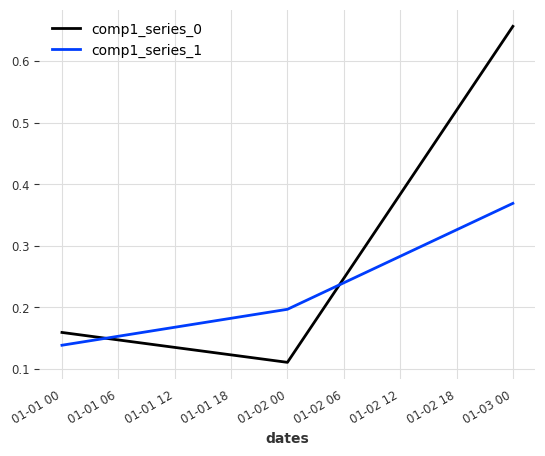

In [9]:
# generate an DataFrame example
df = pd.DataFrame(
    data={
        "dates": [
            "2020-01-01",
            "2020-01-02",
            "2020-01-03",
            "2020-01-01",
            "2020-01-02",
            "2020-01-03",
        ],
        "comp1": np.random.random((6,)),
        "comp2": np.random.random((6,)),
        "comp3": np.random.random((6,)),
        "ID": ["SERIES1", "SERIES1", "SERIES1", "SERIES2", "SERIES2", "SERIES2"],
        "var1": [0.5, 0.5, 0.5, 0.75, 0.75, 0.75],
    }
)
print("Input DataFrame")
print(df)

series_multi = TimeSeries.from_group_dataframe(
    df,
    time_col="dates",
    group_cols="ID",  # individual time series are extracted by grouping `df` by `group_cols`
    static_cols=[
        "var1"
    ],  # also extract these additional columns as static covariates (without grouping)
    value_cols=[
        "comp1",
        "comp2",
        "comp3",
    ],  # optionally, specify the time varying columns
)

print(f"\n{len(series_multi)} series were extracted from the input DataFrame")
for i, ts in enumerate(series_multi):
    print(f"Static covariates of series {i}")
    print(ts.static_covariates)
    ts["comp1"].plot(label=f"comp1_series_{i}")

### 5. Scaling/Encoding/Transforming static covariate data
There might be the need to scale numeric static covariates or encode categorical static covariates as not all models can handle non numeric static covariates. 

Use `StaticCovariatesTransformer` (see the docs [here](https://unit8co.github.io/darts/generated_api/darts.dataprocessing.transformers.static_covariates_transformer.html#staticcovariatestransformer)) to scale/transform static covariates. By default it uses a `MinMaxScaler` to scale numeric data, and a `OrdinalEncoder` to encode categorical data.
Both the numeric and categorical transformers will be fit globally on static covariate data of all time series passed to `StaticCovariatesTransformer.fit()`

In [10]:
from darts.dataprocessing.transformers import StaticCovariatesTransformer

transformer = StaticCovariatesTransformer()
series_transformed = transformer.fit_transform(series_multi)

for i, (ts, ts_scaled) in enumerate(zip(series_multi, series_transformed)):
    print(f"Original series {i}")
    print(ts.static_covariates)
    print(f"Transformed series {i}")
    print(ts_scaled.static_covariates)
    print("")

Original series 0
static_covariates       ID  var1
global_components  SERIES1   0.5
Transformed series 0
static_covariates   ID  var1
global_components  0.0   0.0

Original series 1
static_covariates       ID  var1
global_components  SERIES2  0.75
Transformed series 1
static_covariates   ID  var1
global_components  1.0   1.0



### 6. Forecasting example with `TFTModel` and static covariates
Now let's find out if adding static covariates to a forecasting problem can improve predictive accuracy.
We'll use `TFTModel` which supports numeric and categorical static covariates.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import TQDMProgressBar

from darts import TimeSeries
from darts.models import TFTModel
from darts.utils import timeseries_generation as tg
from darts.dataprocessing.transformers import StaticCovariatesTransformer
from darts.metrics import rmse

#### 6.1 Experiment setup
For our experiment, we generate two time series: a fully sine wave series (label = smooth) and sine wave series with some irregularities every other period (label = irregular, see the ramps at periods 2 and 4).

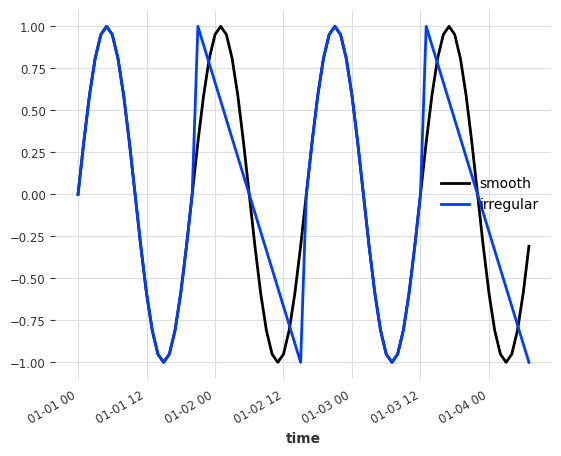

In [12]:
period = 20
sine_series = tg.sine_timeseries(
    length=4 * period, value_frequency=1 / period, column_name="smooth", freq="h"
)

sine_vals = sine_series.values()
linear_vals = np.expand_dims(np.linspace(1, -1, num=19), -1)

sine_vals[21:40] = linear_vals
sine_vals[61:80] = linear_vals
irregular_series = TimeSeries.from_times_and_values(
    values=sine_vals, times=sine_series.time_index, columns=["irregular"]
)
sine_series.plot()
irregular_series.plot()

We will use three different setups for training and evaluation:

1. fit/predict without static covariates
2. fit/predict with binary (numeric) static covariates
3. fit/predict with categorical static covariates

For each setup we'll train the model on both series and then only use only the 3rd period (sine wave for both series) to predict the 4th period (sine for "smooth" and ramp for "irregular").

What we hope for is that the model without static covariates performs worse than the other ones. The non-static model should not be able to recognize whether the underlying series used in `predict()` is the *smooth* or the *irregular* series as it only gets a sine wave curve as input (3rd period). This should result in a forecast somewhere inbetween the smooth and irregular series (learned by minimizing the global loss during training).

Now this is where static covariates can really help. For example, we can embed data about the curve type into the **target** series through static covariates. With this information, we'd expect the models to generate improved forecasts.

First we create some helper functions to apply the same experiment conditions to all models.

In [13]:
def test_case(model, train_series, predict_series):
    """helper function which performs model training, prediction and plotting"""
    model.fit(train_series)
    preds = model.predict(n=int(period / 2), num_samples=250, series=predict_series)
    for ts, ps in zip(train_series, preds):
        ts.plot()
        ps.plot()
        plt.show()
    return preds


def get_model_params():
    """helper function that generates model parameters with a new Progress Bar object"""
    return {
        "input_chunk_length": int(period / 2),
        "output_chunk_length": int(period / 2),
        "add_encoders": {
            "datetime_attribute": {"future": ["hour"]}
        },  # TFTModel requires future input, with this we won't have to supply any future_covariates
        "random_state": 42,
        "n_epochs": 150,
        "pl_trainer_kwargs": {
            "callbacks": [TQDMProgressBar(refresh_rate=4)],
        },
    }

### 6.2 Forecasting without static covariates
Let's train the first model without any static covariates

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

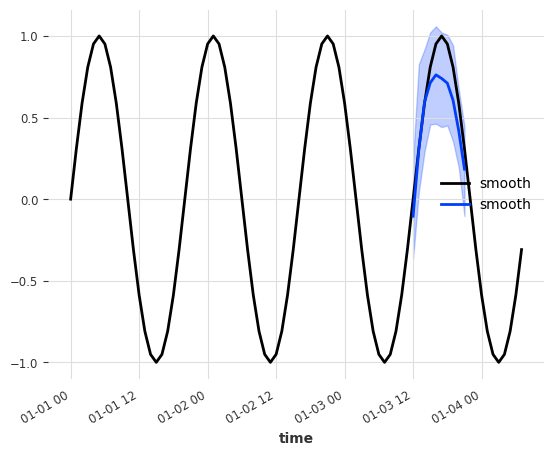

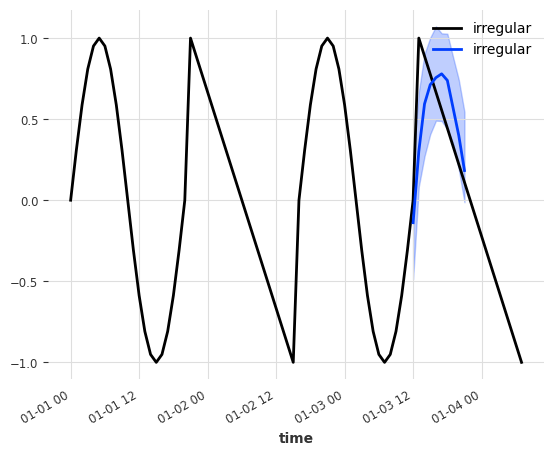

In [14]:
train_series = [sine_series, irregular_series]
for series in train_series:
    assert not series.has_static_covariates

model = TFTModel(**get_model_params())
preds = test_case(
    model,
    train_series,
    predict_series=[series[:60] for series in train_series],
)

From the plot you can see that the forecast began after period 3 (~01-03-2022 - 12:00). The prediciton input were the last `input_chunk_length=10` values - which are identical for both series (sine wave).

As expected, the model was not able to determine the type of the underlying prediciton series (smooth or irregular) and generate a sine-wave like forecast for both.

### 6.3 Forecasting with 0/1 binary static covariates (numeric)

Now let's repeat the experiment but this time we add information about the curve type as a binary (numeric) static covariate named `"curve_type"`.

static_covariates  curve_type
component                    
smooth                    1.0
static_covariates  curve_type
component                    
irregular                 0.0


Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

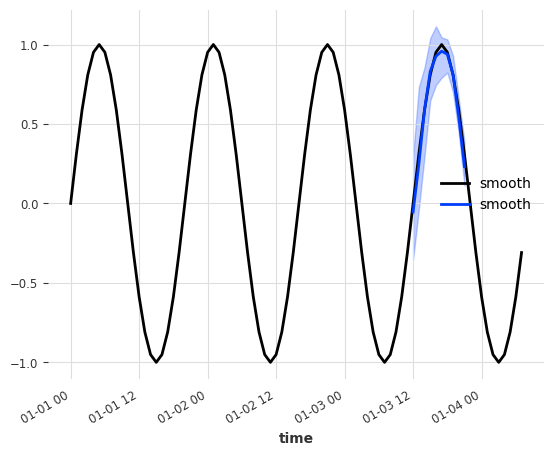

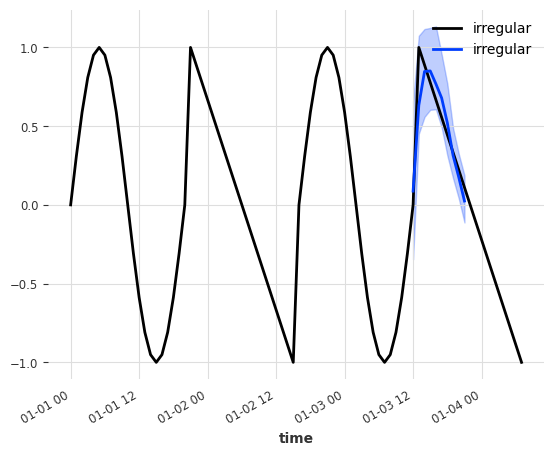

In [15]:
sine_series_st_bin = sine_series.with_static_covariates(
    pd.DataFrame(data={"curve_type": [1]})
)
irregular_series_st_bin = irregular_series.with_static_covariates(
    pd.DataFrame(data={"curve_type": [0]})
)

train_series = [sine_series_st_bin, irregular_series_st_bin]
for series in train_series:
    print(series.static_covariates)

model = TFTModel(**get_model_params())
preds_st_bin = test_case(
    model,
    train_series,
    predict_series=[series[:60] for series in train_series],
)

That already looks much better! The model was able to identify the curve type/category from the binary static covariate feature.

### 6.4 Forecasting with categorical static covariates
The last experiment already showed promising results. So why not only use binary features for categorical data?
While it might have worked well for our two time series, if we had more curve types we'd need to one hot encode 
the feature into a binary variable for each category. With a lot of categories, this lead to a large number of 
features/predictors and multicollinearity which can lower the model's predictive accuracy.

As a last experiment, let's use the curve type as a categorical feature. `TFTModel` learns an embedding for categorical features.
Darts' `TorchForecastingModels` (such as `TFTModel`) only support numeric data. Before training we need to transform the `"curve_type"` into a integer-valued feature with `StaticCovariatesTransformer` (see section 5.). 

In [16]:
sine_series_st_cat = sine_series.with_static_covariates(
    pd.DataFrame(data={"curve_type": ["smooth"]})
)
irregular_series_st_cat = irregular_series.with_static_covariates(
    pd.DataFrame(data={"curve_type": ["non_smooth"]})
)

train_series = [sine_series_st_cat, irregular_series_st_cat]
print("Static covariates before encoding:")
print(train_series[0].static_covariates)

# use StaticCovariatesTransformer to encode categorical static covariates into numeric data
scaler = StaticCovariatesTransformer()
train_series = scaler.fit_transform(train_series)
print("\nStatic covariates after encoding:")
print(train_series[0].static_covariates)

Static covariates before encoding:
static_covariates curve_type
component                   
smooth                smooth

Static covariates after encoding:
static_covariates  curve_type
component                    
smooth                    1.0


No all we need to do is tell `TFTModel` that `"curve_type"` is a categorical variable that requires embedding.
We can do so with model parameter `categorical_embedding_sizes` which is a dictionary of: {feature name: (number of categories, embedding size)}


Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

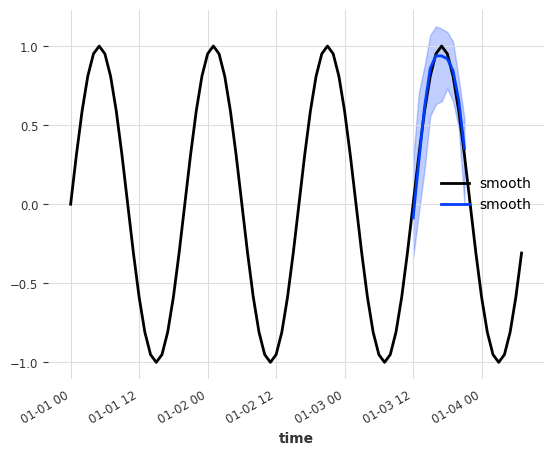

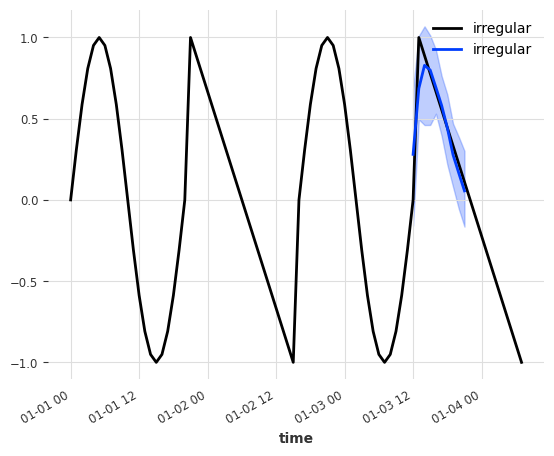

In [17]:
n_categories = 2  # "smooth" and "non_smooth"
embedding_size = 2  # embed the categorical variable into a numeric vector of size 2
categorical_embedding_sizes = {"curve_type": (n_categories, embedding_size)}

model = TFTModel(
    categorical_embedding_sizes=categorical_embedding_sizes, **get_model_params()
)
preds_st_cat = test_case(
    model,
    train_series,
    predict_series=[series[:60] for series in train_series],
)

Nice, that seems to have worked as well! As a last step, let's look at how the models performed compared to each other.

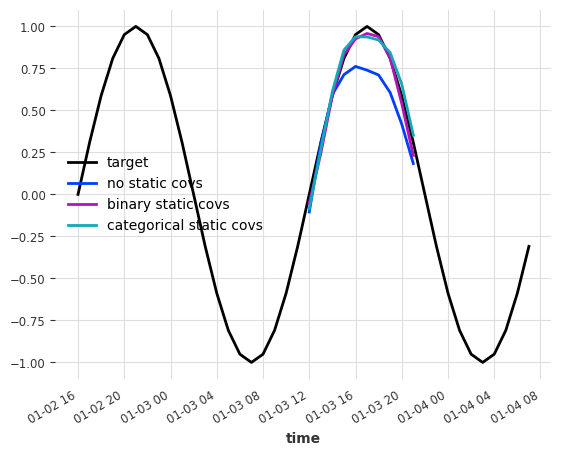

Metric
        no st    bin st    cat st
RMSE  0.16352  0.042527  0.050242


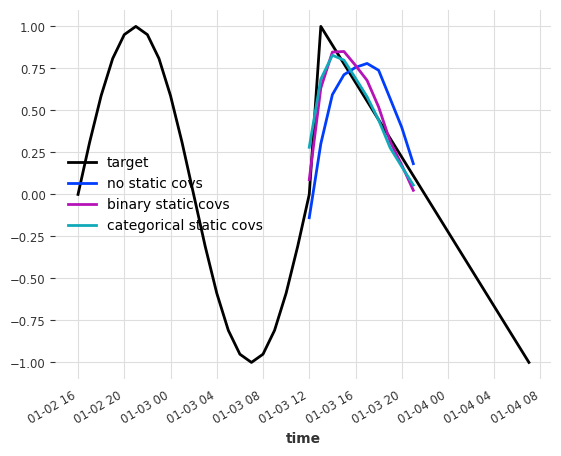

Metric
         no st    bin st    cat st
RMSE  0.289051  0.138122  0.138631


In [18]:
for series, ps_no_st, ps_st_bin, ps_st_cat in zip(
    train_series, preds, preds_st_bin, preds_st_cat
):
    series[-40:].plot(label="target")
    ps_no_st.quantile(0.5).plot(label="no static covs")
    ps_st_bin.quantile(0.5).plot(label="binary static covs")
    ps_st_cat.quantile(0.5).plot(label="categorical static covs")
    plt.show()
    print("Metric")
    print(
        pd.DataFrame(
            {
                name: [rmse(series, ps)]
                for name, ps in zip(
                    ["no st", "bin st", "cat st"], [ps_no_st, ps_st_bin, ps_st_cat]
                )
            },
            index=["RMSE"],
        )
    )

These are great results! Both approaches using static covariates decreased the RMSE by more than halve for both series compared to the baseline!

*Note that we only used one static covariate feature, but you can use as many as want including mixtures of data types (numeric and categorical).*